In [2]:
import ROOT
from ROOT import TFile, TCanvas, TH1D
import numpy as np
from Plotter.PlotterTools.ObsAndExp import ObsAndExp
from Parameters import cvs_params, info_params, hist_params

Welcome to JupyROOT 6.22/08


In [27]:
# Define global variables
f = TFile.Open("ZFake_3Mu.root")
PROPMTs = ["rare", "conv", "ttX", "VV"]
SYSTs = ["Central", "L1PrefireUp", "L1PrefireDown", "PUReweightUp", "PUReweightDown", "IDSFUp", "IDSFDown", "TrigSFUp", "TrigSFDown"]
histkey = "jets/3/pt"
hists = dict()

In [28]:
def get_data_hist(histkey):
    base_dir = f.Get("data")
    h = base_dir.Get(histkey)
    h.SetDirectory(0)
    return h
def get_fake_hist(histkey, syst="Central"):
    base_dir = f.Get("fake/"+syst)
    h = base_dir.Get(histkey)
    h.SetDirectory(0)
    return h
def get_hist(mc, histkey, syst="Central"):
    base_dir = f.Get(mc+"/"+syst)
    h = base_dir.Get(histkey)
    h.SetDirectory(0)
    return h

In [29]:
h_data = get_data_hist(histkey)
h_fake = get_fake_hist(histkey)
h_mc = get_hist("VV", histkey)

In [30]:
h_data = get_data_hist(histkey)

# estimate systematics for fake
h_fakes = dict()
h_fakes["Central"] = get_fake_hist(histkey, syst="Central")
h_fakes["Up"] = get_fake_hist(histkey, syst="Up")
h_fakes["Down"] = get_fake_hist(histkey, syst="Down")

h_fake = h_fakes["Central"].Clone("h_fake")
h_fake.SetDirectory(0)
bins = h_fake.GetMaximumBin()
for bin in range(bins+1):
    center = h_fake.GetBinContent(bin)
    upper = h_fakes["Up"].GetBinContent(bin) - center
    lower = center - h_fakes["Down"].GetBinContent(bin)
    gm = pow(pow(upper, 2) + pow(lower, 2), 0.5)
    h_fake.SetBinError(bin, gm)

hists['fake'] = h_fake

In [31]:
for mc in PROPMTs:
    # get all systmatics
    temp = dict()
    # get histograms
    for syst in SYSTs:
        temp[syst] = get_hist(mc, histkey, syst)     
    h = temp["Central"].Clone("h_"+mc)
    h.SetDirectory(0)
    bins = h.GetMaximumBin()
    for bin in range(bins+1):
        center = h.GetBinContent(bin)
        error = pow(h.GetBinError(bin), 2)
        for syst in SYSTs:
            error += pow(temp[syst].GetBinContent(bin) - center, 2)
        error = np.sqrt(error)
        h.SetBinError(bin, error)
    hists[mc] = h

INFO: Storing histograms...
INFO: y axis range set to be maximum of data plot
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cvs


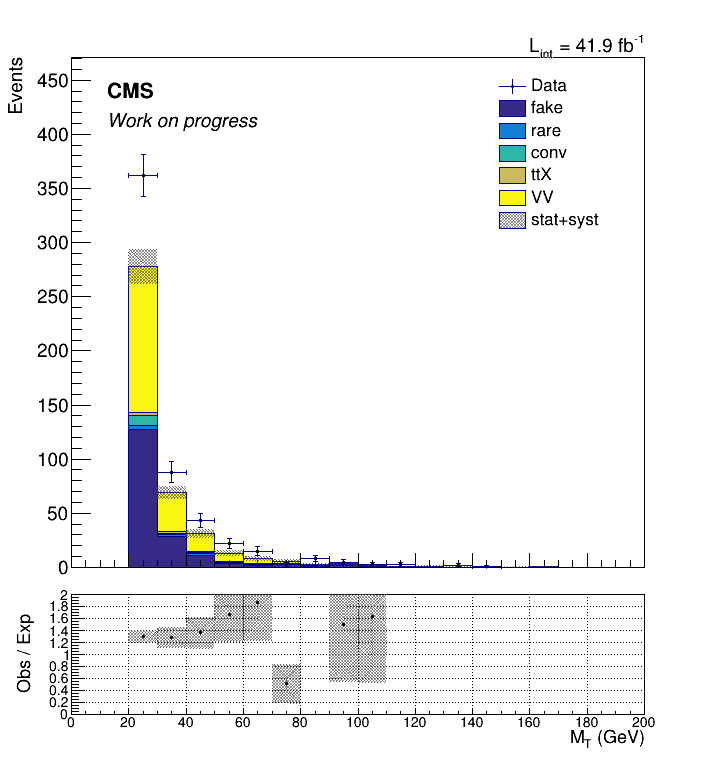

In [32]:
# plot
cvs_params = {
    "logy": False,
    "grid": False
}
info_params = {
    "info": "L_{int} = 41.9 fb^{-1}",
    "cms_text": "CMS",
    "extra_text": "Work on progress"
}
hist_params = {
    "x_title": "M_{T} (GeV)",
    "x_range": [0., 200.],
    "y_title": "Events",
    "rebin": 10,
    "ratio_range": [0., 2.0]
}

plotter = ObsAndExp(cvs_params, hist_params, info_params)
plotter.get_hists(h_data, hists)
plotter.combine()
plotter.draw()